In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load in the data
Same as we did in the metric learning, let's load back in the dataset.

In [2]:
# define input files
COMPOSITIONS_FILE = "data/oh2016_species_relative_abundance.csv"
METADATA_FILE = "data/oh2016_metadata.csv"

First we'll load in the microbial compositions of each sample. These are the proportions that each species takes up of the entire sample.

In [3]:
# load in the species abundance table
compositions_df = pd.read_csv(COMPOSITIONS_FILE, index_col="names").transpose() / 100
compositions_df.head()

(585, 2259)

Next to the compositions, we also have some metadata for each sample:

In [5]:
# load in the metadata
metadata_df = pd.read_csv(METADATA_FILE, index_col="Sample")
to_drop = [i for i in metadata_df.index if i not in compositions_df.index]
metadata_df.drop(index=to_drop, inplace=True)

metadata_df.head()

(616, 9)
(585, 9)


,Person,Origin,Gender,Age at time of sampling,Date Collected,Timepoint,Site-Symmetry,Method,Site characteristic
Sample,,,,,,,,,
MET0001,person_03,2014 study,Female,30s,06.24.11,First,Ac-L,Ss,moist
MET0002,person_03,2014 study,Female,30s,06.24.11,First,Ph-L,Ss,moist
MET0009,person_01,2014 study,Male,30s,09.30.11,First,Gb-null,Ss,sebaceous
MET0011,person_01,2014 study,Male,30s,09.30.11,First,Ch-R,Ss,sebaceous
MET0012,person_01,2014 study,Male,30s,09.30.11,First,Al-R,Ss,sebaceous


In [467]:
# how many samples do we have per person?
print(np.unique(metadata_df.Person, return_counts=True))

(array(['person_01', 'person_02', 'person_03', 'person_04', 'person_05',
       'person_06', 'person_07', 'person_08', 'person_09', 'person_10',
       'person_11', 'person_12'], dtype=object), array([51, 50, 49, 49, 43, 49, 41, 51, 51, 50, 51, 50]))


# Learning characteristics from the data

In the metadata, we have a collection of characteristics for each individual/sample. In this case, `Gender` might be the most interesting, since we can imagine that the skin microbiome differs between men and women. While we could do some data science to figure out these exact differences, we can make the computer do the work for us by having it learn from this dataset what the difference is between the two groups. If it is able to make this distinction well, we can then let it make predictions for new samples (of which we might not know the origin).

## Some quick concepts in passing
Note that we are using the gender-characteristic as the label for our model to learn here, but in theory we could do this for any characteristic.

The gender outcome in this dataset only has two categorical states: 'Male' and 'Female'. In machine learning terms, this thus becomes a **binary classification problem**. Machine learning can also be done on more than two states for a variable (like we did in the metric learning of 12 individuals), and it can also be done on continuous variables (like if we wanted to predict a person's height or weight), in that case it is called a **regression problem**. Different types of machine learning algorithms - like the Naïve Bayes we will use here - are fine-tuned for specific problems.

## Split off a 'train' and 'test' set
To get an idea of how good our machine learning model is at identifying a person's gender from their skin microbiome, we want to see how well it works on data it has not seen before. To do this, we will first split off a few samples from the data before we train a model on it. We will then train the model and see how well it can predict on the samples we kept from it, *i.e.*, the testing set.

In [468]:
compositions_train, compositions_test, labels_train, labels_test = train_test_split(compositions_df, metadata_df["Gender"], test_size=0.2, random_state=42, stratify=metadata_df["Gender"]) # we stratify to make sure the ratio male/female samples is the same in our train and test sets

## Naïve Bayes
Naive Bayes methods are a set of supervised learning algorithms based on Bayes’ theorem. There are multiple versions of Naïve Bayes methods that differ slightly in implementation and input-data. Since our input data here are continuous values between 0 and 1, we'll go with a Gaussian Naïve Bayes.

For a quick introduction on Naive Bayes models, you can check out the page on scikit learn: https://scikit-learn.org/stable/modules/naive_bayes.html

In [469]:
# Fit a model to learn the relation between microbiome-gender in this dataset
nb_model = GaussianNB(var_smoothing=1e-7)
nb_model.fit(compositions_train, labels_train)

GaussianNB(var_smoothing=1e-07)

## Predicting
We can now try to predict the gender of each of the samples in our test set that we kept hidden from the machine learning model. Naïve Bayes has some nice built-in functions to do this:

In [470]:
labels_pred = nb_model.predict(compositions_test)

## Checking performance
We can then check how accurate our model is by comparing the predicted labels with the actual labels. As a baseline, we can compare it to purely random guessed, which should reach a performance of ~1/12 = 8.33%.

In [471]:
# check the accuracy
nb_accuracy = round(accuracy_score(labels_test, labels_pred) * 100, 2)
print(f"{nb_accuracy}% of samples were correctly characterized using the Naïve Bayes method.")

75.21% of samples were correctly characterized using the Naïve Bayes method.


We can look at some more specific metrics as well:

In [472]:
print("==================== NB metrics =====================")
print(classification_report(labels_test, labels_pred, target_names=np.unique(metadata_df["Gender"])))

==================== NB metrics =====================
              precision    recall  f1-score   support

      Female       0.83      0.50      0.62        48
        Male       0.73      0.93      0.82        69

    accuracy                           0.75       117
   macro avg       0.78      0.71      0.72       117
weighted avg       0.77      0.75      0.74       117



We can see that our model is able to predict gender quite well. It can do this a little better for males than for females, but that might be due to the fact that our dataset has more male samples in general.

## Interpreting
As it seems definite that our algorithm has grabbed onto true signal, we can learn from our fitted model to see what the most important species are. 

We can do this with a permutation test. This test will leave out each species and will test how much this affects the accuracy of our model. Species for which the accuracy is heavily affected will thus be important to the model.

In [534]:
imps = permutation_importance(nb_model, compositions_test, labels_test)

# let's look only at species whose inclusion affect the model's accuracy by at least 0.5%
important_species = {k:v for (k,v) in zip(compositions_df.columns, imps.importances_mean) if np.abs(v) >= 0.005}
important_species

{'Corynebacterium_kroppenstedtii': 0.013675213675213627,
 'Propionibacterium_acidipropionici': 0.008547008547008517,
 'Weeksella_virosa': 0.00512820512820511,
 'Enterococcus_casseliflavus': 0.00512820512820511,
 'Lactococcus_lactis': 0.006837606837606813,
 'Anaerococcus_prevotii': 0.00512820512820511,
 'Yersinia_pestis': -0.00512820512820511,
 'Pseudomonas_entomophila': -0.00854700854700854,
 'Pseudomonas_putida': -0.0068376068376068576,
 'Puccinia_triticina': 0.006837606837606813,
 'uncultured_phage': 0.006837606837606813,
 'Human_papillomavirus': 0.011965811965811923,
 'Macaca_fascicularis_papillomavirus': -0.0051282051282051325,
 'Acheta_domestica_densovirus': 0.03931623931623931,
 'Merkel_cell_polyomavirus': 0.0512820512820513,
 'Polyomavirus_HPyV6': 0.008547008547008517,
 'Polyomavirus_HPyV7': 0.011965811965811923,
 'Simian_virus': 0.008547008547008517,
 'Acinetobacter_bacteriophage': 0.008547008547008517,
 'Actinomyces_phage': 0.01025641025641022,
 'Pseudomonas_phage': -0.0085470

The above list of species pop out as being important to the distinction. And indeed, if we plot out the abundances of these species in men and women separately, we see some differences.

### Some species-specific plots

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Merkel_cell_polyomavirus', ylabel='Density'>

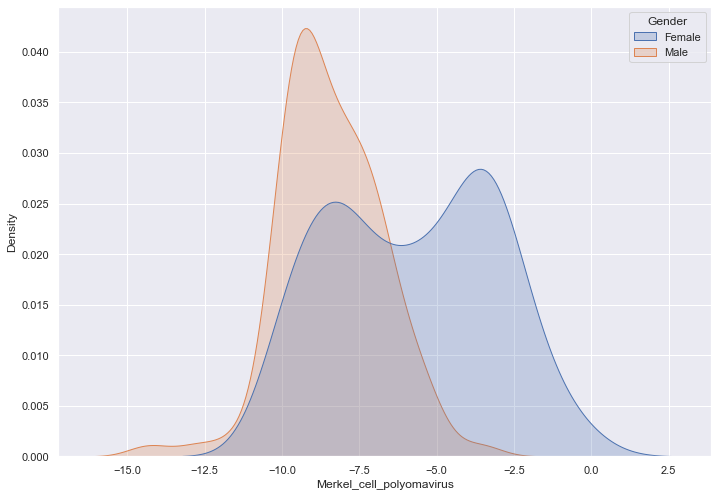

In [533]:
# a density plot of the log-transformed abundances of Merkel cell polyomavirus in males
spec = "Merkel_cell_polyomavirus"
sb.kdeplot(np.log(compositions_df[spec]), hue=metadata_df["Gender"], shade=True)

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Yersinia_pestis', ylabel='Density'>

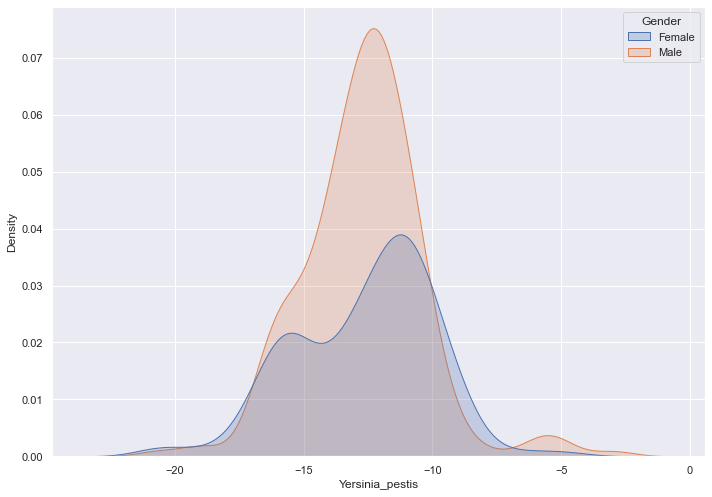

In [535]:
spec = "Yersinia_pestis" # this is the bacterium that caused the black plague... not really sure what it is doing in here
sb.kdeplot(np.log(compositions_df[spec]), hue=metadata_df["Gender"], shade=True)

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


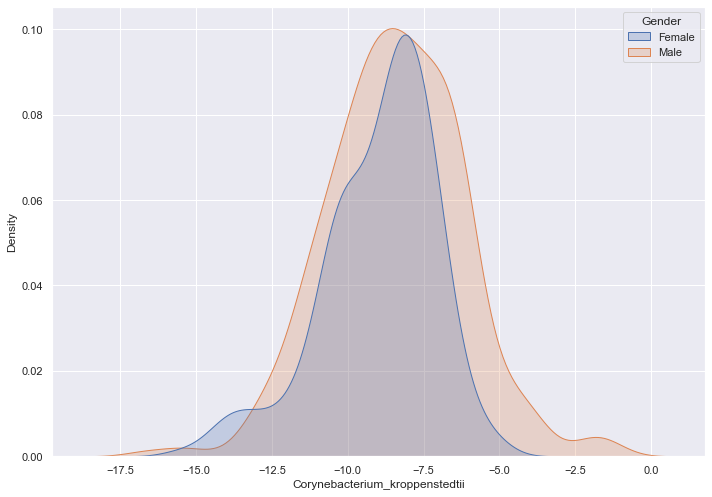

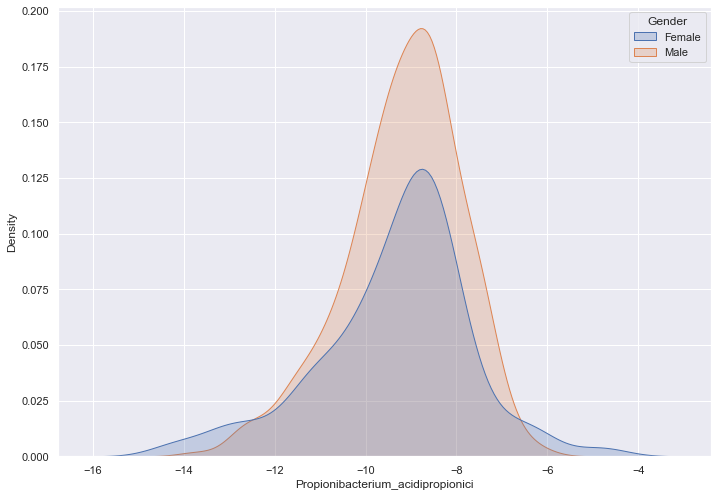

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


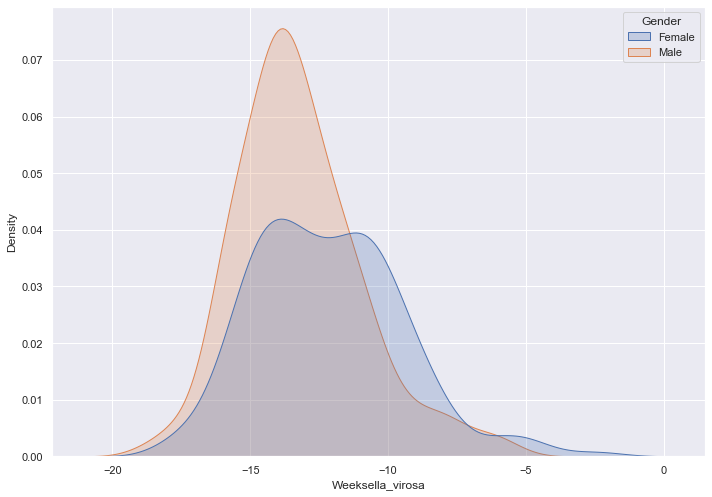

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


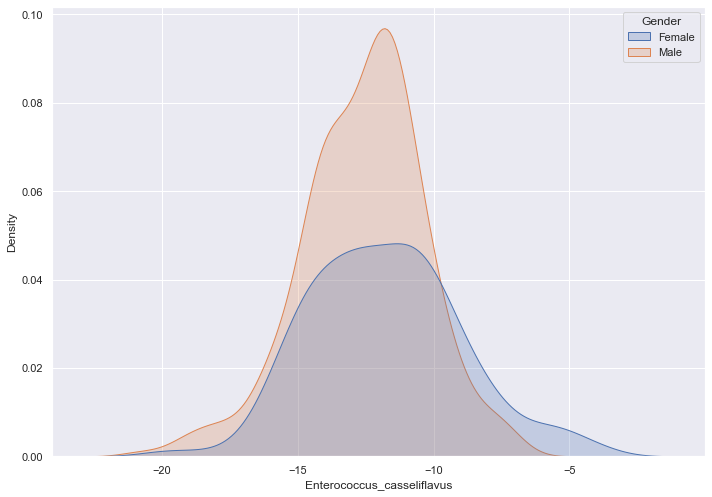

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


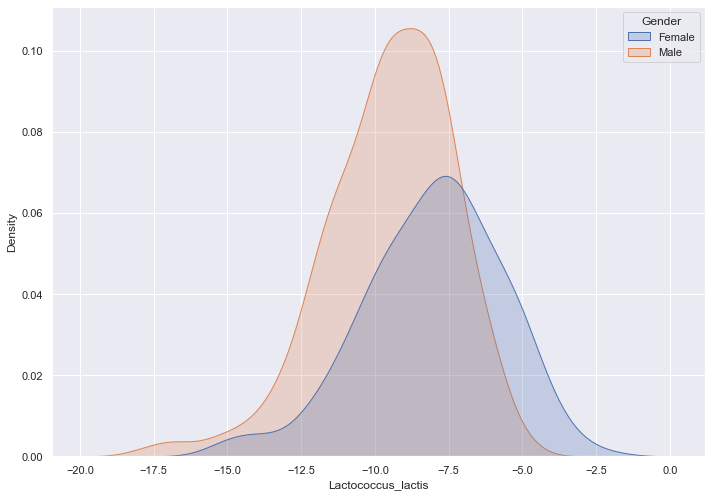

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


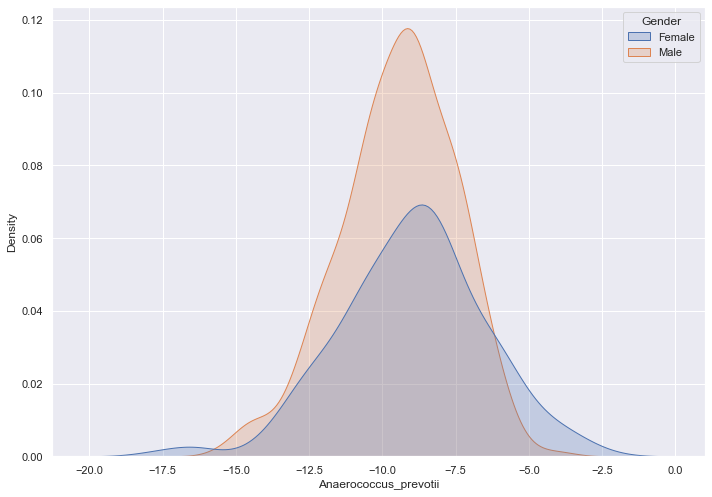

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


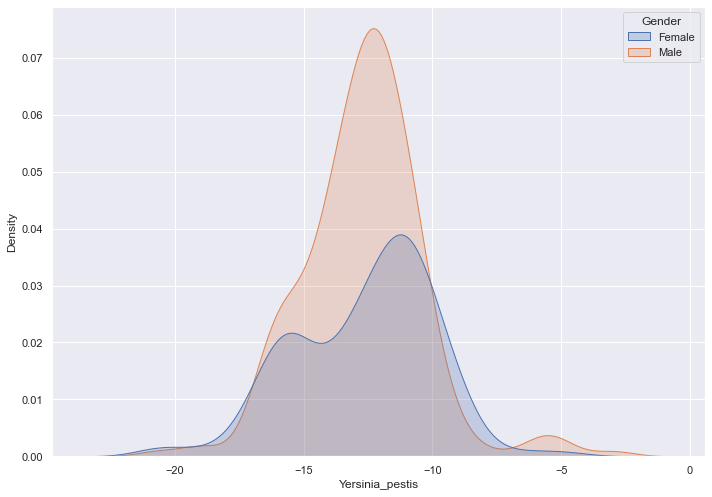

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


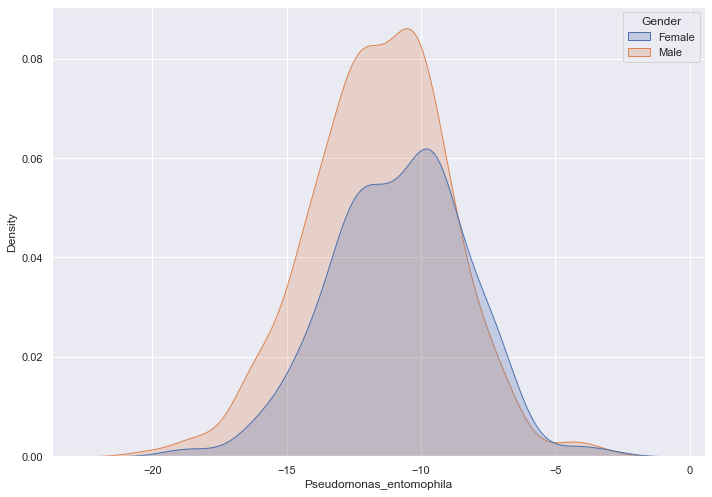

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


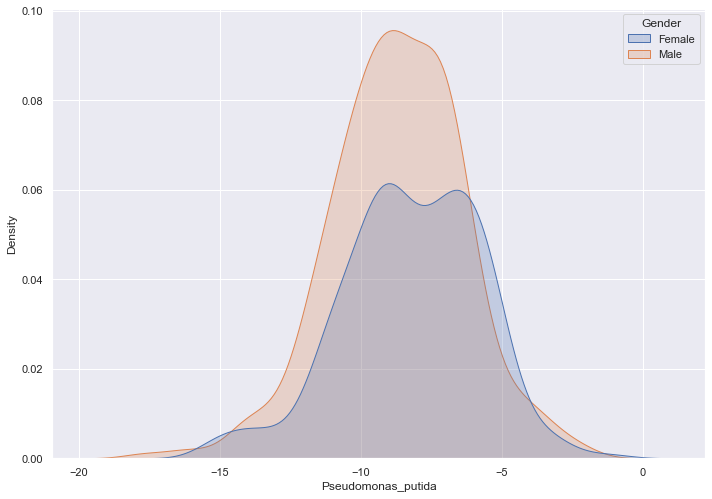

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


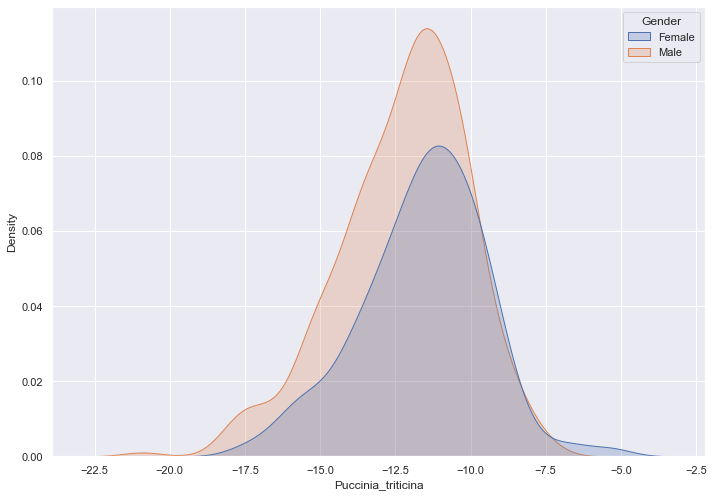

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


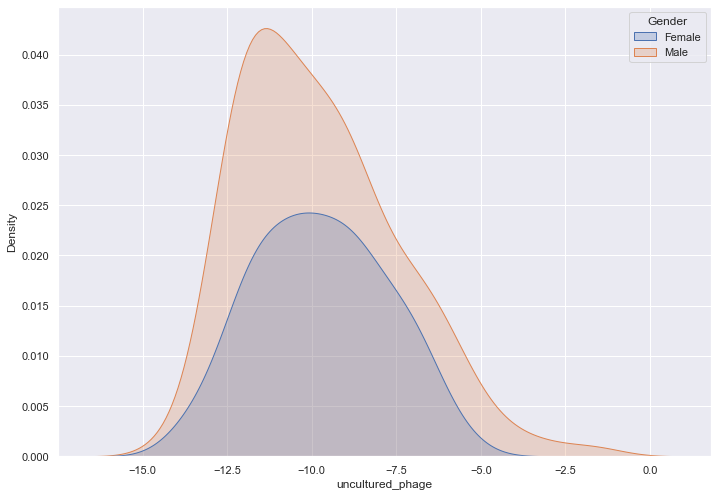

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


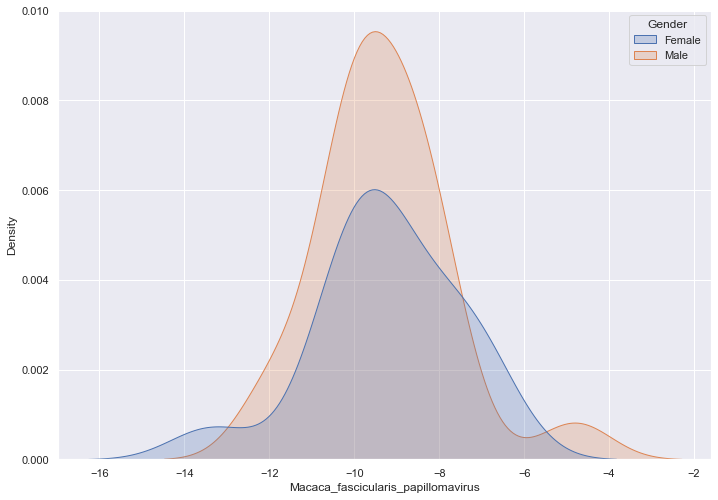

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


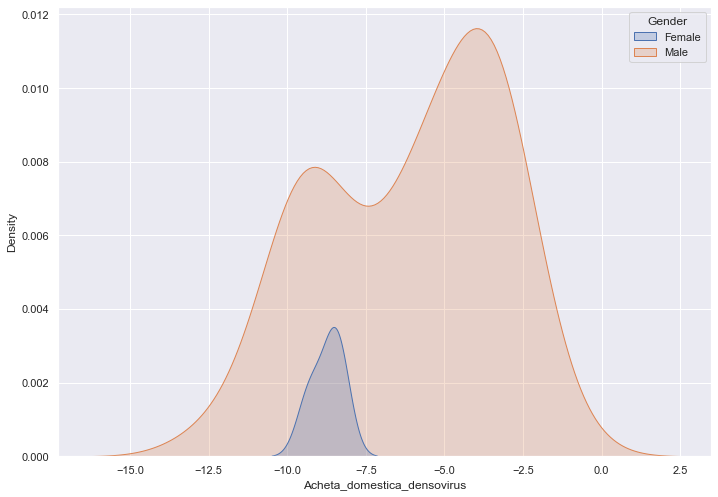

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


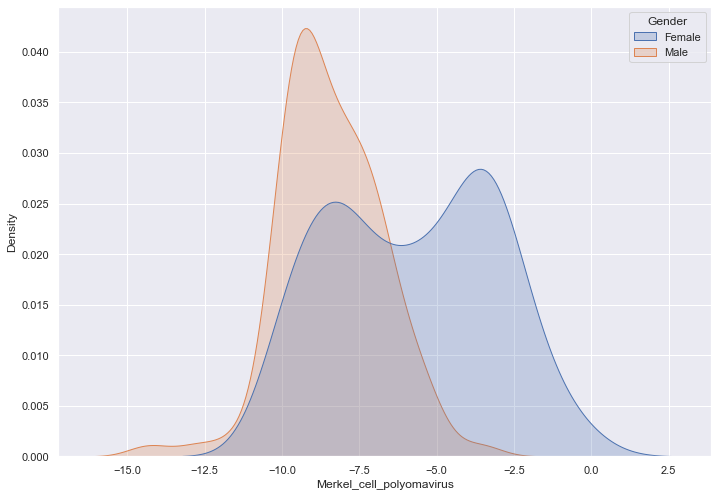

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


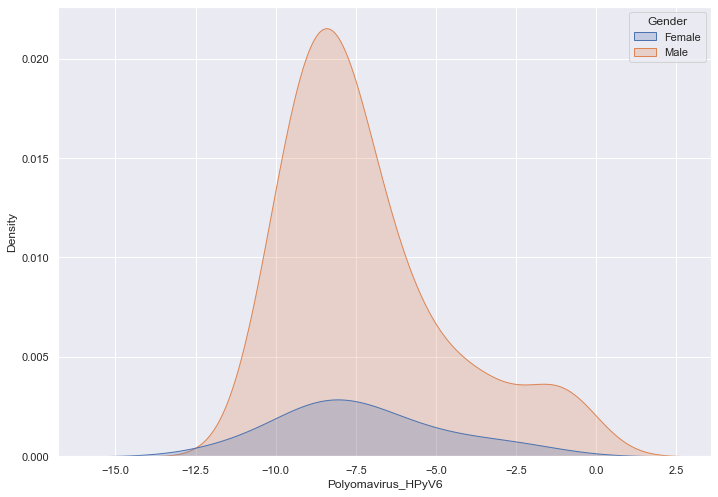

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


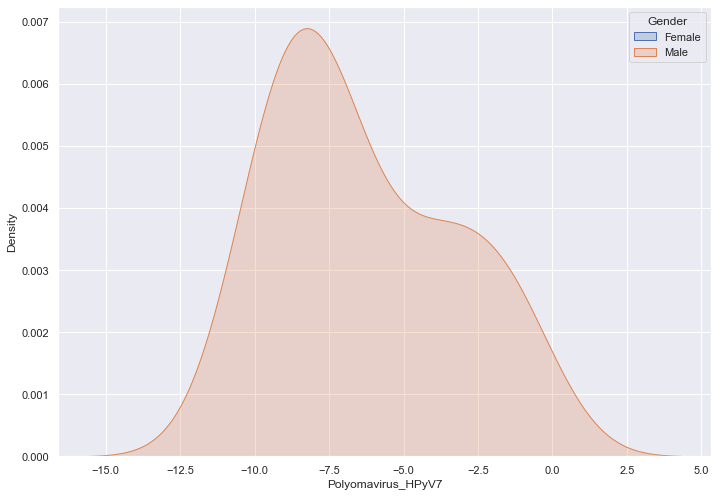

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


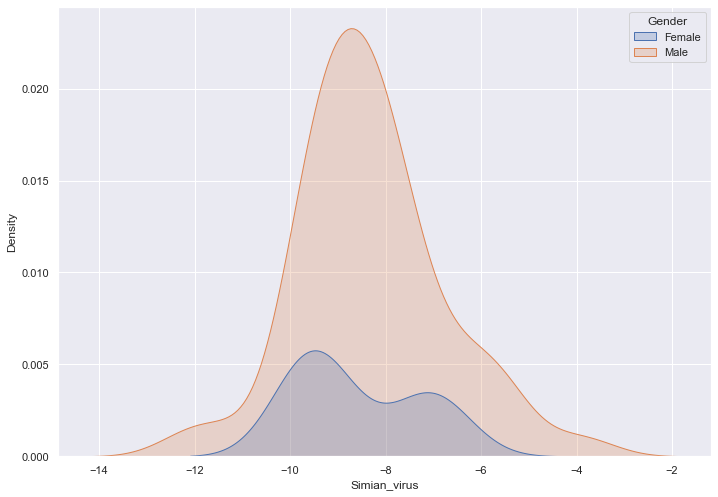

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


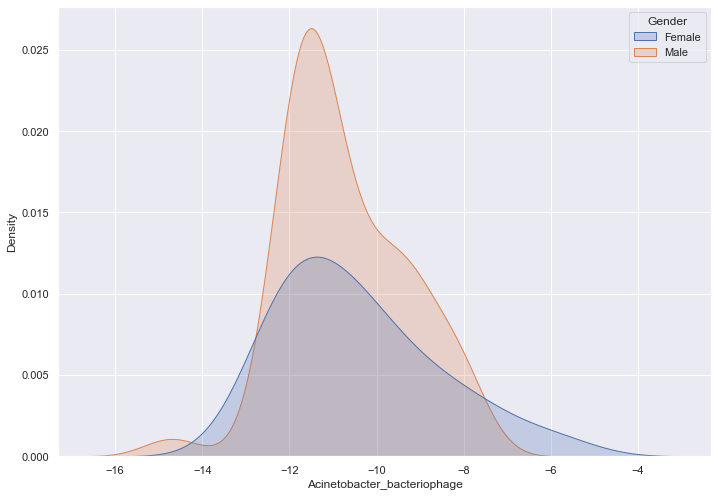

/Users/stefftaelman/miniconda3/envs/reidentification/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


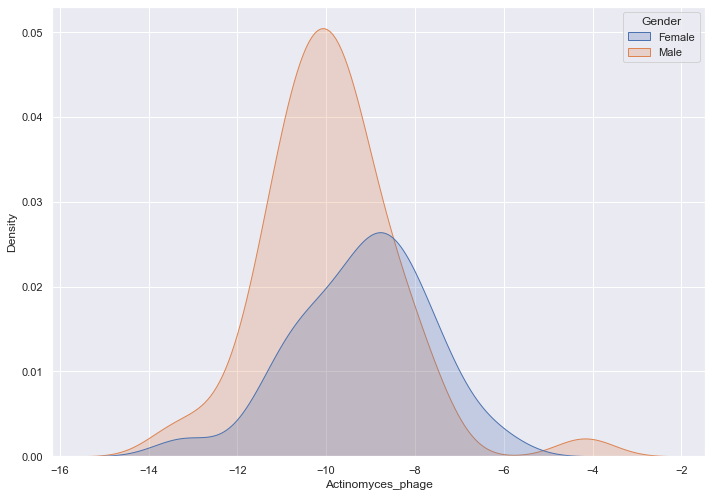

In [554]:
for spec in important_species.keys():
    if len(compositions_df[spec].shape) == 1:
        sb.kdeplot(np.log(compositions_df[spec]), hue=metadata_df["Gender"], shade=True)
        plt.show()

**Open question:** Are these species specifically mentioned in literature in relation to the skin microbiome in men and women? Can we hypothese why we are seeing this difference (and will it be reliable for forensic research)?